# 自動車の走行距離予測  
https://signate.jp/competitions/121  
上記のデータコンペ練習問題に取り組んだ。  

目的変数は、mpg (=ガソリン１ガロンあたりの走行距離)。  
testデータの説明変数から、mpg予測するモデルを作成。  
評価指標は、RMSE。

id (int):  インデックスとして使用  
mpg (float):  ガソリン１ガロンあたりの走行距離（mile par gallon の略）  
cylinders (varchar):  シリンダー  
displacement (float):  排気量  
horsepower (float):  馬力  
weight (float):  重量  
acceleration (float):  加速度  
model year (varchar):  年式  
origin (varchar):  起源  
car name (varchar):  車名  
  

# 全体のまとめ
< EDA >  
データの概観確認、データの分布確認、変数間の相関確認を行なった。
 
 
< モデル構築 >
説明変数を、[mpg, cylinders, displacement, horsepower, weight, acceleration, model year, origin]、目的変数は'mpg'としてモデルを作成・学習し、学習したモデルで評価用データの説明変数から予測した予測値と評価用データの目的変数から精度(RMSE)を評価した。  

モデル①  
hold-outでtrainデータを学習用データ:評価用データ = 7:3に分割してのモデル学習(線形回帰モデル)と精度(RMSE)評価を行なった。   
trainデータでのRMSE: 3.33であった。    
提出結果: 3.41  

モデル②  
RepeatedKFoldで、trainデータを5分割してのモデル学習(線形回帰モデル)と精度(RMSE)評価を3回行なった。  
trainデータでのRMSE: 3.26
提出結果: 3.40

モデル③  
説明変数(特徴量)を多項式特徴量(degree=2)に変換。   
RepeatedKFoldで、trainデータを5分割してのモデル学習(線形回帰モデル)と精度(RMSE)評価を3回行なった。  
rainデータでのRMSE: 3.30    
提出結果: 3.00  

モデル④  
hold-outでtrainデータを学習用データ:評価用データ = 7:3に分割してのモデル学習(線形回帰モデル)と精度(RMSE)評価を行なった。   
trainデータでのRMSE: 3.31であった。    
提出結果: 3.38    
  
モデル⑤  
hold-outでtrainデータを学習用データ:評価用データ = 7:3に分割してのモデル学習(線形回帰モデル)と精度(RMSE)評価を行なった。   
trainデータでのRMSE: 3.26であった。    
提出結果: 3.50  
    

In [97]:
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold, RepeatedKFold, cross_val_score

In [8]:
# データ読み込み
train = pd.read_csv('train.tsv', sep='\t')
test = pd.read_csv('test.tsv', sep='\t')
submit = pd.read_csv('sample_submit.csv', header=None)
print(f'train_shape:{train.shape}, test_shape:{test.shape}')

train_shape:(199, 10), test_shape:(199, 9)


## データの確認   
・データ型、欠損値、重複値を確認する   
・データ型がobjectとなっていたhorsepowerカラムについて、一部データに値を補完してカラムのデータ型をfloat型に変換。   
  

In [9]:
train.head()

,id,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,0,29.0,4,135.0,84.00,2525.0,16.0,82,1,dodge aries se
1,3,31.9,4,89.0,71.00,1925.0,14.0,79,2,vw rabbit custom
2,9,19.0,6,156.0,108.0,2930.0,15.5,76,3,toyota mark ii
3,11,28.0,4,90.0,75.00,2125.0,14.5,74,1,dodge colt
4,13,37.7,4,89.0,62.00,2050.0,17.3,81,3,toyota tercel


In [10]:
train.info()
# trainデータ欠損値、データ型を確認。
# horsepowerのデータ型がobjectになっているので注意する

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            199 non-null    int64  
 1   mpg           199 non-null    float64
 2   cylinders     199 non-null    int64  
 3   displacement  199 non-null    float64
 4   horsepower    199 non-null    object 
 5   weight        199 non-null    float64
 6   acceleration  199 non-null    float64
 7   model year    199 non-null    int64  
 8   origin        199 non-null    int64  
 9   car name      199 non-null    object 
dtypes: float64(4), int64(4), object(2)
memory usage: 15.7+ KB


In [11]:
test.info()
# testデータ欠損値、データ型を確認。
# こちらもhorsepowerのデータ型がobjectになっている

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            199 non-null    int64  
 1   cylinders     199 non-null    int64  
 2   displacement  199 non-null    float64
 3   horsepower    199 non-null    object 
 4   weight        199 non-null    float64
 5   acceleration  199 non-null    float64
 6   model year    199 non-null    int64  
 7   origin        199 non-null    int64  
 8   car name      199 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 14.1+ KB


In [12]:
train = train.drop(columns=['id'])
test = test.drop(columns=['id'])

In [13]:
train[train.duplicated()]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name


In [14]:
test[test.duplicated()]

,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name


In [15]:
# train, testいずれも欠損値・重複値はないことを確認

In [16]:
train['horsepower'].unique()
# trainデータのhorsepowerカラムに'?'という値が入っているため、データ型がobjectになっている

array(['84.00', '71.00', '108.0', '75.00', '62.00', '90.00', '105.0',
       '180.0', '113.0', '135.0', '120.0', '88.00', '165.0', '100.0',
       '69.00', '70.00', '60.00', '80.00', '132.0', '85.00', '130.0',
       '93.00', '?', '175.0', '68.00', '58.00', '110.0', '65.00', '67.00',
       '78.00', '48.00', '112.0', '86.00', '83.00', '81.00', '82.00',
       '92.00', '97.00', '76.00', '193.0', '148.0', '72.00', '170.0',
       '140.0', '220.0', '79.00', '198.0', '150.0', '64.00', '96.00',
       '138.0', '52.00', '145.0', '95.00', '160.0', '74.00', '54.00',
       '149.0', '139.0', '129.0', '63.00', '122.0', '200.0', '46.00',
       '153.0', '89.00', '155.0', '61.00', '215.0', '190.0', '115.0'],
      dtype=object)

In [17]:
test['horsepower'].unique()
# testデータにも同様に'?'が含まれている

array(['76.00', '98.00', '92.00', '110.0', '88.00', '90.00', '150.0',
       '105.0', '190.0', '75.00', '175.0', '65.00', '87.00', '77.00',
       '140.0', '67.00', '48.00', '170.0', '155.0', '84.00', '70.00',
       '60.00', '95.00', '215.0', '52.00', '180.0', '71.00', '49.00',
       '68.00', '63.00', '103.0', '85.00', '80.00', '152.0', '58.00',
       '79.00', '86.00', '78.00', '?', '100.0', '69.00', '145.0', '230.0',
       '125.0', '115.0', '130.0', '198.0', '94.00', '153.0', '83.00',
       '208.0', '46.00', '137.0', '142.0', '72.00', '102.0', '81.00',
       '66.00', '165.0', '160.0', '225.0', '97.00', '53.00', '120.0',
       '167.0', '210.0', '74.00', '129.0', '133.0', '158.0', '107.0',
       '116.0', '91.00'], dtype=object)

In [18]:
train[train['horsepower'] == '?']
# trainデータで'?'の値が入っているデータは４つ。horsepowerの中央値を補完することにする。

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
24,23.0,4,151.0,?,3035.0,20.5,82,1,amc concord dl
113,34.5,4,100.0,?,2320.0,15.8,81,2,renault 18i
145,40.9,4,85.0,?,1835.0,17.3,80,2,renault lecar deluxe
175,25.0,4,98.0,?,2046.0,19.0,71,1,ford pinto


In [19]:
test[test['horsepower'] == '?']
# testデータで'?'の値が入っているデータは４つ。こちらもhorsepowerの中央値を補完することにする。

,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
70,6,200.0,?,2875.0,17.0,74,1,ford maverick
112,4,140.0,?,2905.0,14.3,80,1,ford mustang cobra


In [20]:
train_hrsp_median =  np.median(train[train['horsepower'] != '?']['horsepower'].astype(np.float64))

In [21]:
test_hrsp_median = np.mean(test[test['horsepower'] != '?']['horsepower'].astype(np.float64))

In [22]:
# '?'が入っているデータに中央値を補完し、データ型をfloatに変換
train['horsepower'] = train['horsepower'].apply(lambda x: train_hrsp_median if x == '?' else x).astype(np.float64)
test['horsepower'] = test['horsepower'].apply(lambda x: test_hrsp_median if x == '?' else x).astype(np.float64)

In [23]:
# horsepowerのデータ型を確認
train['horsepower'].dtypes

dtype('float64')

## 値の分布の確認
<確認のまとめ>  
・シリンダー4つのものが最も多い(112データ)。他、8つのもの(44データ)と6つ(41データ)のものがある。  
・排気量の分布は、左に偏っている。排気量100〜150のものが多い。一部、排気量の多いもの(300〜450)もある。  
・馬力も、排気量と同じく左に偏った分布。75〜125までのものが多い。  
・重量も、排気量・馬力と同じく左に偏った分布。  
・加速度は、左右対称に近いが、若干左に偏った分布となっている。加速度14〜16のものが多い。  
・originは、1が多い。  

In [24]:
train.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
count,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000
mean,24.307035,5.296482,183.311558,101.110553,2883.839196,15.647739,76.165829,1.582915
std,7.797665,1.644562,98.400457,35.225505,819.766870,2.701885,3.802928,0.798932
min,9.000000,3.000000,71.000000,46.000000,1613.000000,8.500000,70.000000,1.000000
25%,18.000000,4.000000,98.000000,75.000000,2217.500000,14.000000,73.000000,1.000000
50%,24.000000,4.000000,140.000000,92.000000,2702.000000,15.500000,76.000000,1.000000
75%,30.500000,6.000000,250.000000,112.500000,3426.500000,17.150000,80.000000,2.000000
max,44.600000,8.000000,454.000000,220.000000,5140.000000,23.700000,82.000000,3.000000


In [25]:
train['cylinders'].value_counts()
# シリンダーは4つのものが最も多い(112データ)。他、8つのもの(44データ)と6つ(41データ)のものがある。

4    112
8     44
6     41
5      1
3      1
Name: cylinders, dtype: int64

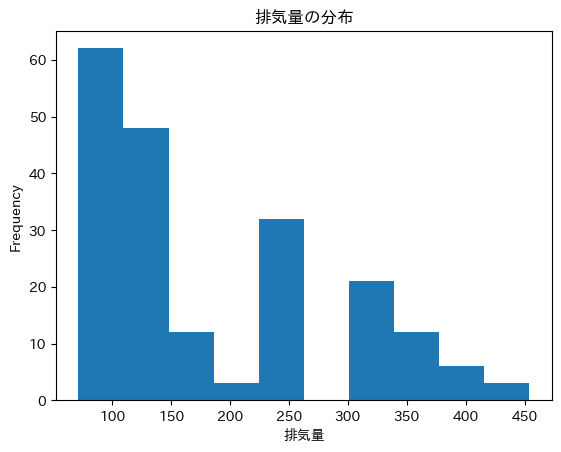

In [26]:
train['displacement'].plot.hist()
plt.title('排気量の分布')
plt.xlabel('排気量')
plt.show()
# 排気量の分布は、左に偏っている。排気量100〜150のものが多い。

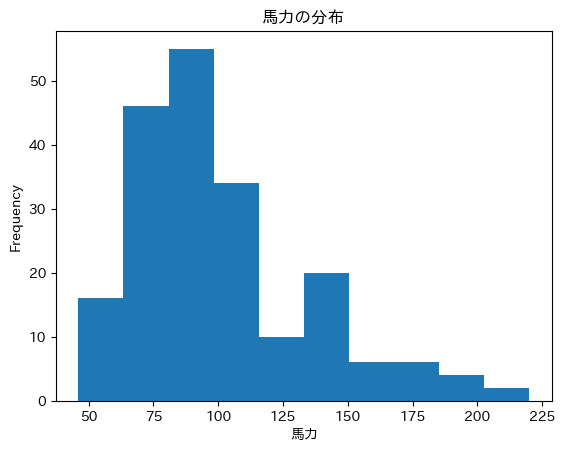

In [27]:
train['horsepower'].plot.hist()
plt.title('馬力の分布')
plt.xlabel('馬力')
plt.show()
# 75〜125までのものが多い。

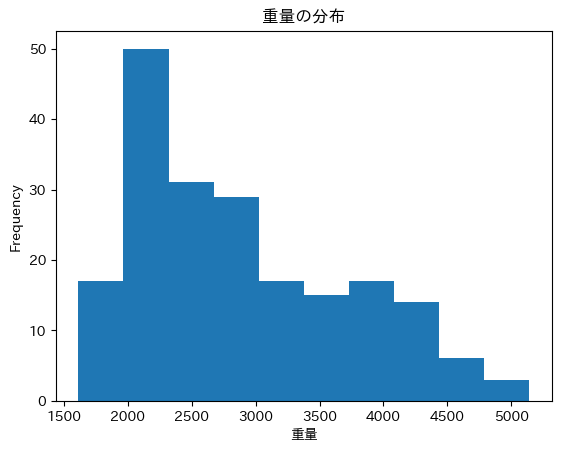

In [28]:
train['weight'].plot.hist()
plt.title('重量の分布')
plt.xlabel('重量')
plt.show()
# 重量も、排気量・馬力と同じく左に偏った分布。

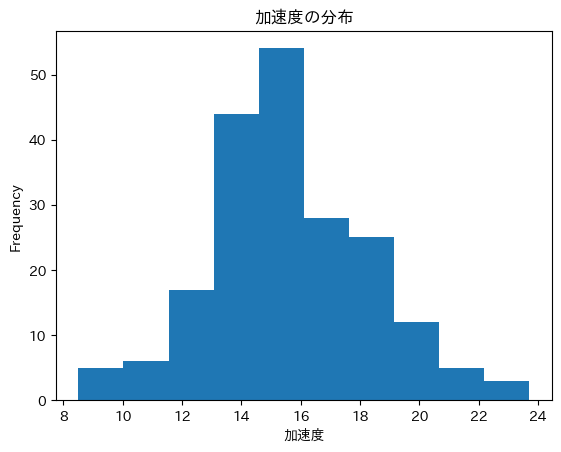

In [29]:
train['acceleration'].plot.hist()
plt.title('加速度の分布')
plt.xlabel('加速度')
plt.show()
# 左右対称に近いが、若干左に偏った分布となっている。加速度14〜16のものが多い。

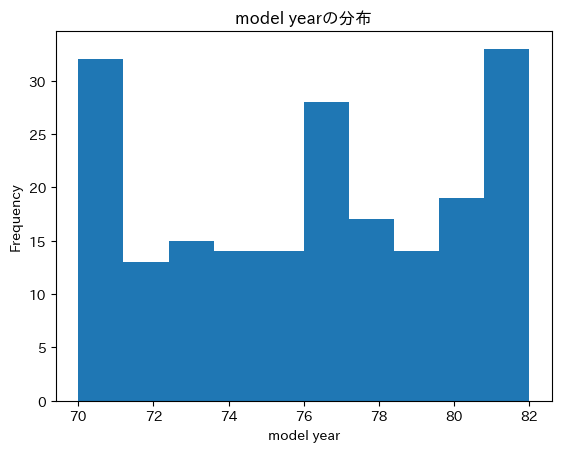

In [30]:
train['model year'].plot.hist()
plt.title('model yearの分布')
plt.xlabel('model year')
plt.show()

In [31]:
train['origin'].value_counts()
# 1が多い

1    122
3     39
2     38
Name: origin, dtype: int64

## 変数間の相関の確認 
<確認のまとめ>  
■目的変数mpgと各変数との相関   
・cylinders, displacement, horsepower, weightと燃費(mpg)は強い負の相関がある (→事前調査と一致)   
・model yearと燃費(mpg)は正の相関がある  
・accelerationと燃費(mpg)は弱い正の相関がある  
・origin=1(USA)だとorigin=2(Europe)や3(Japan)のときよりも燃費が小さくなる  
  
■その他各変数どうしの相関  
・cylinders, displacement, horsepower, weightはそれぞれ強い正の相関がある  
・cylinders, displacement, horsepower, weightはaccelerationと負の相関がある。  
・origin=2と3は、origin=1の場合よりcylinders, displacement, horsepower, weightが小さい傾向にある  
・model yearとcylinders, displacement, horsepower, weightは弱い負の相関がある。  

In [32]:
train.corr()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
mpg,1.000000,-0.770160,-0.804635,-0.782601,-0.820660,0.379721,0.568471,0.533671
cylinders,-0.770160,1.000000,0.950600,0.849718,0.893256,-0.479561,-0.303462,-0.497373
displacement,-0.804635,0.950600,1.000000,0.892460,0.933038,-0.523955,-0.329817,-0.579805
horsepower,-0.782601,0.849718,0.892460,1.000000,0.868336,-0.657461,-0.380886,-0.419367
weight,-0.820660,0.893256,0.933038,0.868336,1.000000,-0.401757,-0.265562,-0.535893
acceleration,0.379721,-0.479561,-0.523955,-0.657461,-0.401757,1.000000,0.194854,0.189193
model year,0.568471,-0.303462,-0.329817,-0.380886,-0.265562,0.194854,1.000000,0.124279
origin,0.533671,-0.497373,-0.579805,-0.419367,-0.535893,0.189193,0.124279,1.000000


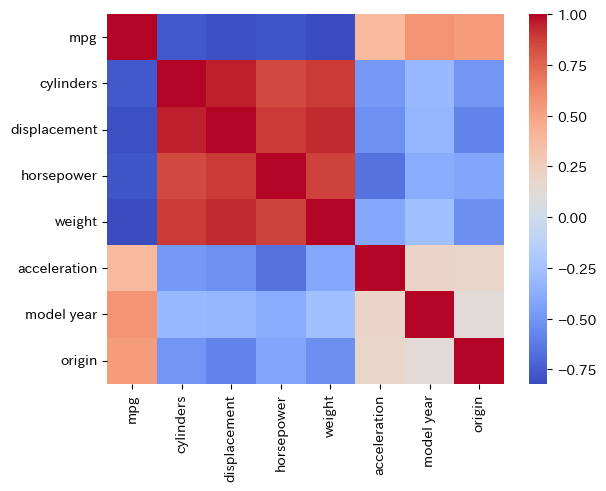

In [33]:
sns.heatmap(train.corr(), cmap='coolwarm')
plt.show()

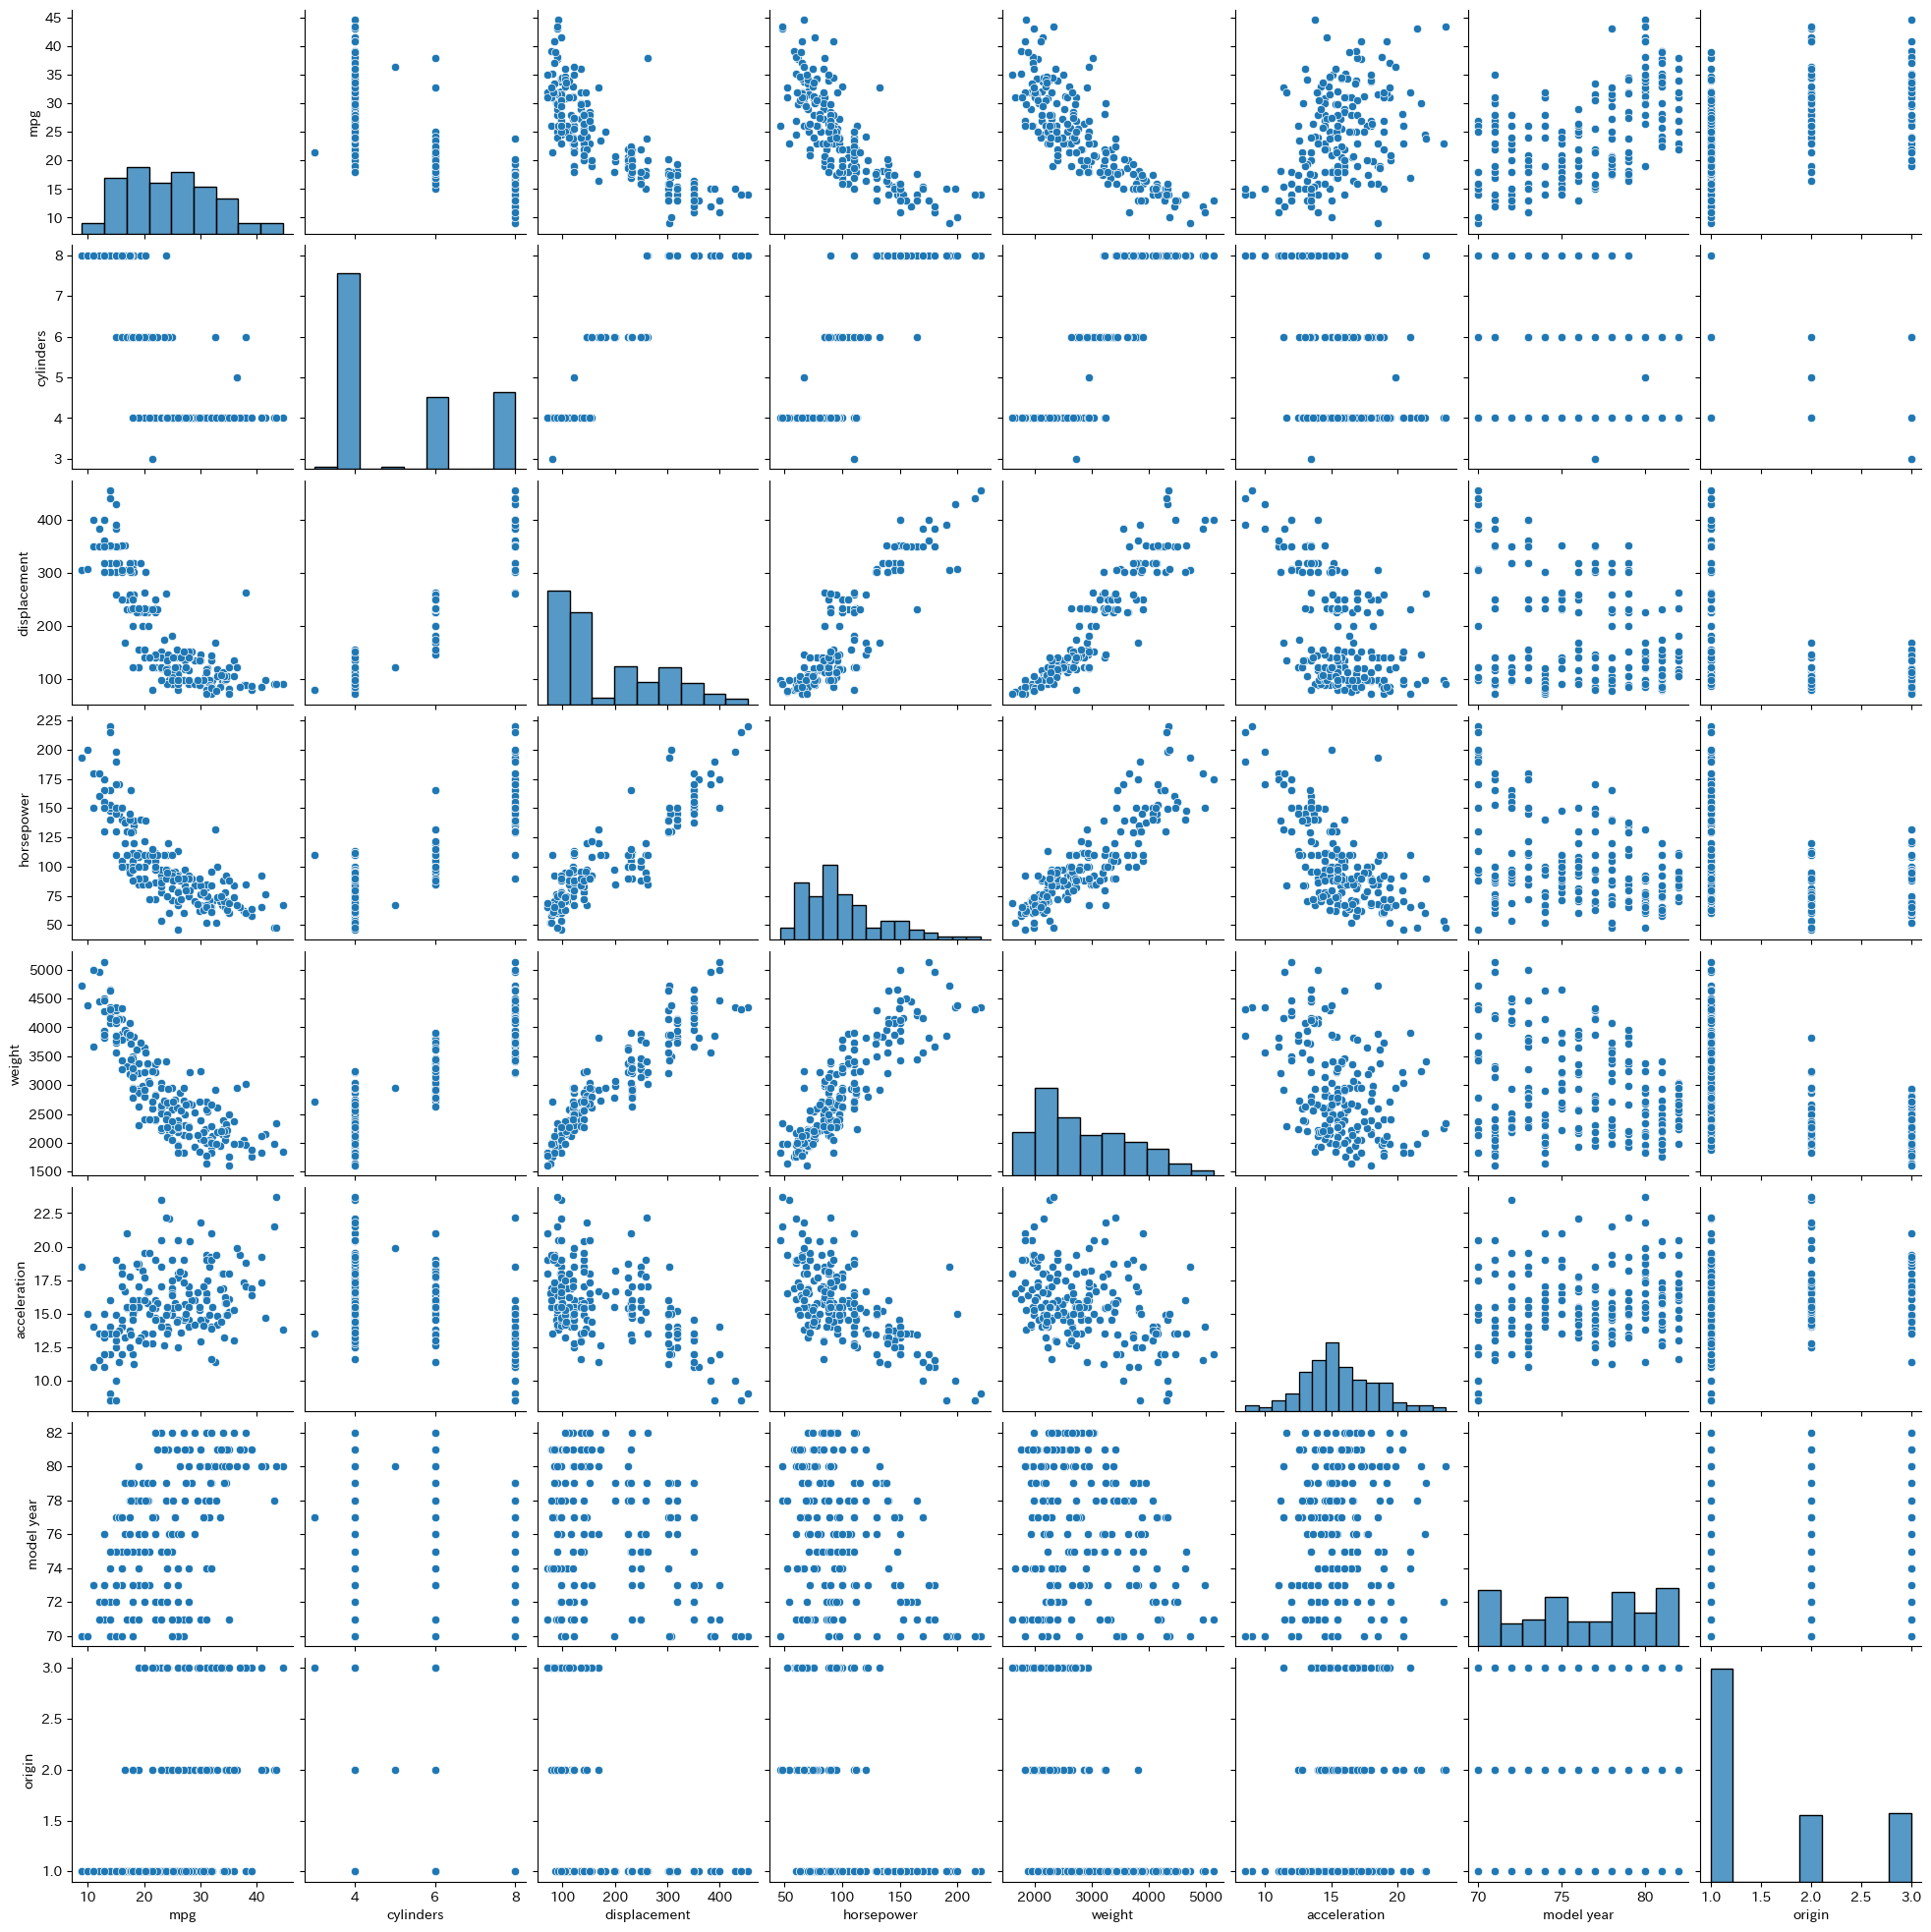

In [34]:
sns.pairplot(train)

## モデル構築①
説明変数は、[mpg, cylinders, displacement, horsepower, weight, acceleration, model year, origin]、目的変数は'mpg'  
hold-outでtrainデータを学習用データ:評価用データ = 7:3に分割。 
線形回帰モデルを作成し、学習用データで学習した。  
学習したモデルで評価用データの説明変数から予測した予測値と評価用データの目的変数から精度(RMSE)を評価した。  
結果、trainデータでのRMSEは3.33であった。  
このモデルから、testデータの'mpg'を予測し、提出。  
提出結果: 3.41  

In [35]:
# 説明変数と目的変数
X = train.drop(columns=['mpg', 'car name'])
y = train['mpg']

In [36]:
# trainデータを学習用と評価用に分割し、学習用データで線形回帰モデル学習
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0)
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [37]:
y_pred_val = lr.predict(X_val)

In [38]:
print('モデル構築① trainデータでのRMSE:', mean_squared_error(y_val, y_pred_val, squared=False))

モデル構築① trainデータでのRMSE: 3.3327566484685236


In [39]:
# testデータの説明変数
X_test = test.drop(columns=['car name'])

In [40]:
pred1 = lr.predict(X_test)

In [41]:
# submit[1] = pred1
# submit.to_csv('submission_1.csv', header=None, index=False)

## モデル構築②
説明変数は、[mpg, cylinders, displacement, horsepower, weight, acceleration, model year, origin]、目的変数は'mpg'  
RepeatedKFoldで、trainデータを5分割してのモデル学習(線形回帰モデル)と精度(RMSE)評価を3回行なった。  
結果、trainデータでのRMSEは3.26であった。  
このモデルから、testデータの'mpg'を予測し、提出。  
提出結果: 3.40

In [42]:
k = 5
n_repeats = 3
# cv = KFold(n_splits=k, shuffle=True, random_state=0)
cv = RepeatedKFold(n_splits=k, n_repeats=n_repeats, random_state=0)
lr2 = LinearRegression()
rmse_list = []
for train_index, val_index in cv.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y[train_index], y[val_index]
    # モデル学習
    lr2.fit(X_train, y_train)
    y_pred_val = lr2.predict(X_val)
    # RMSE
    rmse = mean_squared_error(y_val, y_pred_val, squared=False)
    rmse_list.append(rmse)

In [43]:
print('モデル構築② trainデータでのRMSE:', np.mean(rmse_list))

モデル構築② trainデータでのRMSE: 3.3687710742834565


In [44]:
# testデータの説明変数
X_test = test.drop(columns=['car name'])

In [45]:
pred2 = lr2.predict(X_test)

In [46]:
# submit[1] = pred2
# submit.to_csv('submission_2.csv', header=None, index=False)

## モデル構築③
説明変数は、[mpg, cylinders, displacement, horsepower, weight, acceleration, model year, origin]、目的変数は'mpg'  
説明変数(特徴量)を多項式特徴量(degree=2)に変換する   
RepeatedKFoldで、trainデータを5分割してのモデル学習(線形回帰モデル)と精度(RMSE)評価を3回行なった。  
結果、trainデータでのRMSEは3.30であった。  
このモデルから、testデータの'mpg'を予測し、提出。  
提出結果: 3.00　

In [47]:
# 説明変数と目的変数
X = train.drop(columns=['mpg', 'car name'])
y = train['mpg']

In [48]:
# 多項式特徴量
poly = PolynomialFeatures(2, include_bias=False)
X_poly = poly.fit_transform(X)

In [49]:
# testデータの説明変数を多項式特徴量に変換
X_test = test.drop(columns=['car name'])
X_poly_test = poly.transform(X_test)

In [50]:
k = 5
n_repeats = 3
cv = RepeatedKFold(n_splits=k, n_repeats=n_repeats, random_state=0)
lr3 = LinearRegression()
rmse_list = []
for train_index, val_index in cv.split(X_poly):
    X_train, X_val = X_poly[train_index], X_poly[val_index]
    y_train, y_val = y[train_index], y[val_index]
    # モデル学習
    lr3.fit(X_train, y_train)
    y_pred_val = lr3.predict(X_val)
    # RMSE
    rmse = mean_squared_error(y_val, y_pred_val, squared=False)
    rmse_list.append(rmse)

In [51]:
print('モデル構築③ trainデータでのRMSE:', np.mean(rmse_list))

モデル構築③ trainデータでのRMSE: 3.3029973420967136


In [52]:
pred3 = lr3.predict(X_poly_test)

In [53]:
# submit[1] = pred3
# submit.to_csv('submission_3.csv', header=None, index=False)

In [55]:
train.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,29.0,4,135.0,84.0,2525.0,16.0,82,1,dodge aries se
1,31.9,4,89.0,71.0,1925.0,14.0,79,2,vw rabbit custom
2,19.0,6,156.0,108.0,2930.0,15.5,76,3,toyota mark ii
3,28.0,4,90.0,75.0,2125.0,14.5,74,1,dodge colt
4,37.7,4,89.0,62.0,2050.0,17.3,81,3,toyota tercel


## モデル構築④
説明変数は、[mpg, cylinders, displacement, horsepower, weight, acceleration, model year, origin]、目的変数は'mpg'  
hold-outでtrainデータを学習用データ:評価用データ = 7:3に分割。 
Lassoモデルを作成し、学習用データで学習した。  
学習したモデルで評価用データの説明変数から予測した予測値と評価用データの目的変数から精度(RMSE)を評価した。  
結果、trainデータでのRMSEは3.31であった。  
このモデルから、testデータの'mpg'を予測し、提出。  
提出結果: 3.38   

In [146]:
# 説明変数と目的変数
X = train.drop(columns=['mpg', 'car name'])
y = train['mpg']

# trainデータを学習用と評価用に分割し、標準化
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# 最もrmseが小さくなるalphaを探索
alphas = np.logspace(-3, 3)
rmse_list = []
coefs = []
for alpha in alphas:
    lasso = Lasso(alpha)
    lasso.fit(X_train, y_train)
    y_pred_val = lasso.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred_val, squared=False)
    rmse_list.append(rmse)
    coefs.append(lasso.coef_)

In [147]:
print(f'lassoが最小となるalpha: {alphas[np.argmin(rmse_list)]:.3f}')
print(f'RMSE最小値: {np.min(rmse_list)}')

lassoが最小となるalpha: 0.212
RMSE最小値: 3.313481394717967


Text(0, 0.5, 'RMSE')

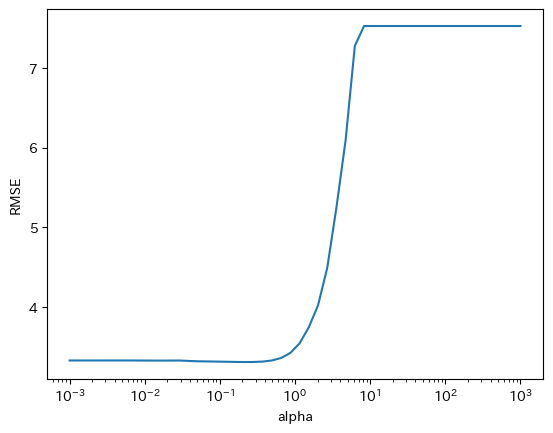

In [148]:
plt.plot(alphas, rmse_list)
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('RMSE')

In [149]:
# lassoが最小となるalphaでモデル学習
lasso = Lasso(alphas[np.argmin(rmse_list)])
lasso.fit(X_train, y_train)

Lasso(alpha=0.21209508879201905)

In [150]:
pd.DataFrame({'coef': lasso.coef_, 'column_name': X.columns.to_list()})
# 'displacement', 'horsepower', 'acceleration'の係数が0となっている

,coef,column_name
0,-0.399690,cylinders
1,-0.000000,displacement
2,-0.000000,horsepower
3,-4.718997,weight
4,0.000000,acceleration
5,2.770930,model year
6,0.820363,origin


In [151]:
# testデータの説明変数
X_test = test.drop(columns=['car name'])
# 説明変数の標準化
X_test = scaler.transform(X_test)

In [152]:
# 学習したモデルからtestデータを予測
pred4 = lasso.predict(X_test)

In [154]:
# submit[1] = pred4
# submit.to_csv('submission_4.csv', header=None, index=False)

## モデル構築⑤
説明変数は、[mpg, cylinders, displacement, horsepower, weight, acceleration, model year, origin]、目的変数は'mpg'  
hold-outでtrainデータを学習用データ:評価用データ = 7:3に分割。 
Ridgeモデルを作成し、学習用データで学習した。  
学習したモデルで評価用データの説明変数から予測した予測値と評価用データの目的変数から精度(RMSE)を評価した。  
結果、trainデータでのRMSEは3.26であった。  
このモデルから、testデータの'mpg'を予測し、提出。  
提出結果: 3.50  

In [155]:
# 説明変数と目的変数
X = train.drop(columns=['mpg', 'car name'])
y = train['mpg']

# trainデータを学習用と評価用に分割し、標準化
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# 最もrmseが小さくなるalphaを探索
alphas = np.logspace(-3, 3)
rmse_list = []
coefs = []
for alpha in alphas:
    ridge = Ridge(alpha)
    ridge.fit(X_train, y_train)
    y_pred_val = ridge.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred_val, squared=False)
    rmse_list.append(rmse)
    coefs.append(ridge.coef_)

In [156]:
print(f'ridgeが最小となるalpha: {alphas[np.argmin(rmse_list)]:.3f}')
print(f'RMSE最小値: {np.min(rmse_list)}')

ridgeが最小となるalpha: 10.985
RMSE最小値: 3.2583797631232465


Text(0, 0.5, 'RMSE')

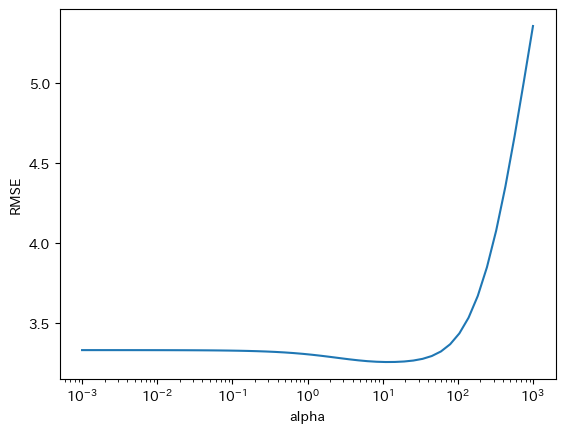

In [157]:
plt.plot(alphas, rmse_list)
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('RMSE')

In [158]:
# lassoが最小となるalphaでモデル学習
ridge = Ridge(alphas[np.argmin(rmse_list)])
ridge.fit(X_train, y_train)

Ridge(alpha=10.985411419875572)

In [159]:
pd.DataFrame({'coef': ridge.coef_, 'column_name': X.columns.to_list()})
# 'displacement', 'horsepower', 'acceleration'の係数が0となっている

,coef,column_name
0,-1.018602,cylinders
1,-0.237895,displacement
2,-0.919297,horsepower
3,-3.162735,weight
4,-0.330490,acceleration
5,2.599267,model year
6,1.047110,origin


In [160]:
# testデータの説明変数
X_test = test.drop(columns=['car name'])
# 説明変数の標準化
X_test = scaler.transform(X_test)

In [163]:
# 学習したモデルからtestデータを予測
pred5 = ridge.predict(X_test)

In [164]:
submit[1] = pred5
submit.to_csv('submission_5.csv', header=None, index=False)